### Info
Plotting comparisons

In [1]:
import numpy as np
import pandas as pd

### Load data into a DataFrame

In [2]:
min_ind = 1
max_ind = 5

model_names = ('hls','qkeras','qonnx_init','qonnx_mod')
pred_all = []   # will be a list of arrays from each model

for model_name in model_names:
    pred_single = np.array([])
    for file_index in range(min_ind, max_ind+1):
        data = np.load('./pred_Test/preds_'+model_name+str(file_index)+'.npy')
        pred_single = np.append(pred_single,data)
        #print(pred_single.shape)
    pred_all.append(pred_single)

pred_all = np.array(pred_all).T

In [3]:
pred_all.shape

(10240, 4)

In [4]:
df = pd.DataFrame(pred_all, columns=model_names)
df

,hls,qkeras,qonnx_init,qonnx_mod
0,0.750,0.750,0.750,0.750
1,1.250,1.250,1.250,1.250
2,3.375,3.375,3.375,3.375
3,1.875,1.875,1.875,1.875
4,2.000,2.000,2.000,2.000
...,...,...,...,...
10235,1.375,1.375,1.375,1.375
10236,2.125,2.125,2.125,2.125
10237,0.875,0.875,0.875,0.875
10238,0.750,0.750,0.750,0.750


### Compare predictions

In [5]:
df['qxinit_qkeras'] = df['qonnx_init'] - df['qkeras']
df['qxinit_qkeras'].value_counts()

qxinit_qkeras
0.0    10240
Name: count, dtype: int64

modified vs unmodified qonnx with respect to hls

In [6]:
df['qxinit_hls'] = df['qonnx_init'] - df['hls']
df['qxmod_hls'] = df['qonnx_mod'] - df['hls']

print(df['qxinit_hls'].value_counts())
print(df['qxmod_hls'].value_counts())

qxinit_hls
0.000      10056
0.125        179
256.000        4
512.000        1
Name: count, dtype: int64
qxmod_hls
0.000      10068
0.125        167
237.750        1
243.500        1
178.125        1
206.125        1
248.625        1
Name: count, dtype: int64


### Create histograms

In [40]:
import matplotlib.pyplot as plt

In [166]:
dfpl = pd.DataFrame([df['qxinit_hls'].value_counts(),df['qxmod_hls'].value_counts()])
dfpl = dfpl.transpose()
dfpl.columns = ['init','mod']
dfpl = dfpl.fillna(0)
dfpl /= dfpl['init'].sum()
dfpl *= 100
dfpl = dfpl.sort_index()
dfpl

,init,mod
0.000,98.203125,98.320312
0.125,1.748047,1.630859
178.125,0.000000,0.009766
206.125,0.000000,0.009766
237.750,0.000000,0.009766
243.500,0.000000,0.009766
248.625,0.000000,0.009766
256.000,0.039062,0.000000
512.000,0.009766,0.000000


In [167]:
diffs = dfpl.index.to_numpy()[1:]
dfpl.keys()[0]

'init'

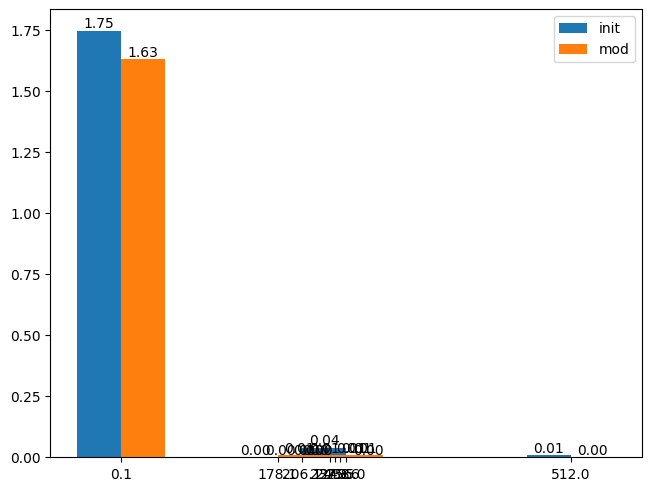

In [168]:
fig, ax = plt.subplots(layout='constrained')
width = 50.

for i in range(len(dfpl.keys())):
    b = ax.bar(diffs+(-1+i)*width, dfpl.values[:,i][1:], width, label=dfpl.keys()[i], align='edge')
    ax.bar_label(b, fmt='{:.2f}')

ax.legend()
ax.set_xticks(diffs)

In [169]:
# Categorize differences (deviations from hls preds)
dfpl['cat'] = dfpl.index.map(lambda x: 
    '0.0' if x==0.0 else(
        '0.125' if x==0.125 else(
            '0.125-250' if x<250.0
            else 'more')
    )
)

catdf = dfpl.groupby('cat').sum()

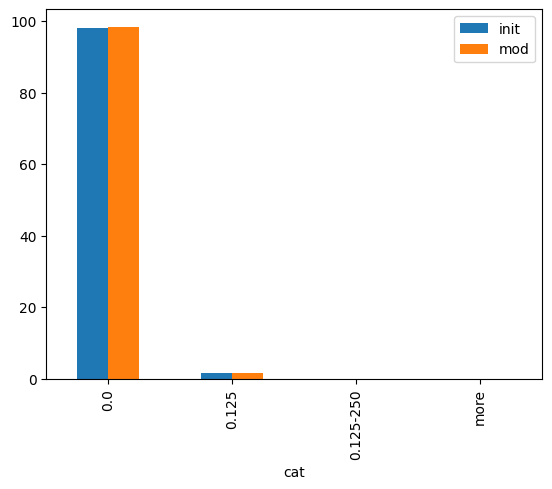

In [170]:
p = catdf.plot.bar()

In [180]:
catdf.values[:,1]

array([9.83203125e+01, 1.63085938e+00, 4.88281250e-02, 0.00000000e+00])

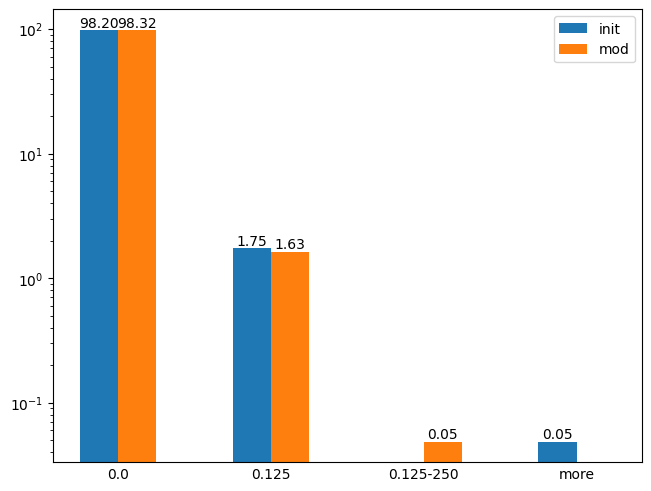

In [194]:
fig, ax = plt.subplots(layout='constrained')
width = 0.25
xticks = np.arange(catdf.shape[0])

for i in range(len(catdf.keys())):
    b = ax.bar(xticks+(-1+i)*width, catdf.values[:,i], width, label=catdf.keys()[i], align='edge')
    ax.bar_label(b, fmt='{:.2f}')

ax.legend()
ax.set_xticks(xticks)
ax.set_xticklabels(catdf.index.to_list())
ax.set_yscale('log')
ax.xaxis.set_tick_params(length=0)